# Synthetic Tax Software User Data Generation

This notebook demonstrates the generation of synthetic data for analyzing the causal impact of the **"Smart Filing Assistant"** feature on user conversion and engagement.

## Business Context

- **Company**: B2C Tax Software Provider
- **Feature**: Smart Filing Assistant (launched globally before 2024 tax season)
- **Challenge**: No A/B test was conducted, so we need causal inference methods
- **Goal**: Estimate causal impact on user conversion and engagement

## Data Structure

Our synthetic dataset includes:
1. **User Demographics**: Age, income, device type, region, etc.
2. **Pre-treatment (2023)**: Baseline filing behavior
3. **Treatment**: Whether user adopted Smart Filing Assistant
4. **Post-treatment (2024)**: Outcomes like conversion, time to complete, satisfaction
5. **Confounders**: Tech-savviness, early login behavior


In [2]:
import os
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.data_simulation import TaxSoftwareDataSimulator, generate_and_save_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Imports successful!")


✅ Imports successful!


## 🔧 **New: Configurable Data Generation**

The data simulation is now **fully parameterized** using YAML configuration files! This eliminates magic numbers and makes experimentation easy.

### **Configuration Features:**
- **📊 All parameters externalized** - No more hard-coded values
- **🎯 Multiple scenarios** - Different configs for sensitivity analysis  
- **🔄 Easy experimentation** - Change parameters without code changes
- **📝 Self-documenting** - YAML files explain each parameter


In [3]:
# Load configuration to see parameters

from src.data_simulation import load_config

# Load the main configuration
config = load_config("../config/simulation_config.yaml")

print("📋 SIMULATION CONFIGURATION PREVIEW")
print("="*50)
print(f"Random seed: {config['simulation']['random_seed']}")
print(f"Default users: {config['simulation']['default_n_users']:,}")
print(f"Treatment base rate: {config['treatment']['base_adoption_rate']:.1%}")
print(f"Treatment base effect: {config['outcomes_2024']['filing']['treatment_effects']['base_effect']:.1%}")

print("\n📊 DEMOGRAPHIC DISTRIBUTIONS:")
for demo_type in ['income_brackets', 'device_types', 'user_types']:
    values = config['demographics'][demo_type]['values']
    weights = config['demographics'][demo_type]['weights']
    print(f"  {demo_type}: {dict(zip(values, weights, strict=False))}")

print("\n🎯 TECH-SAVVINESS PARAMETERS:")
tech_config = config['tech_savviness']
print(f"  Base score: {tech_config['base_score']}")
print(f"  Young boost (age < {tech_config['age_adjustments']['young_threshold']}): +{tech_config['age_adjustments']['young_boost']}")
print(f"  High income boost: +{tech_config['income_adjustments']['high_income_boost']}")

print("\\n✅ All parameters are now configurable in YAML files!")


📋 SIMULATION CONFIGURATION PREVIEW
Random seed: 42
Default users: 10,000
Treatment base rate: 40.0%
Treatment base effect: 8.0%

📊 DEMOGRAPHIC DISTRIBUTIONS:
  income_brackets: {'<30k': 0.15, '30k-50k': 0.2, '50k-75k': 0.25, '75k-100k': 0.2, '100k-150k': 0.15, '>150k': 0.05}
  device_types: {'mobile': 0.45, 'desktop': 0.5, 'tablet': 0.05}
  user_types: {'new': 0.35, 'returning': 0.65}

🎯 TECH-SAVVINESS PARAMETERS:
  Base score: 50
  Young boost (age < 35): +20
  High income boost: +15
\n✅ All parameters are now configurable in YAML files!


## 🎛️ **Multiple Scenario Comparison**

Let's generate datasets with different configurations to see how parameters affect outcomes:


In [4]:
# Generate datasets with different scenarios

scenarios = {
    'baseline': '../config/simulation_config.yaml',
    'high_treatment': '../config/scenario_high_treatment.yaml',
    'low_adoption': '../config/scenario_low_adoption.yaml'
}

results = {}
sample_size = 5000  # Smaller for demo

print("🔄 GENERATING MULTIPLE SCENARIOS")
print("="*50)

for scenario_name, config_path in scenarios.items():
    if os.path.exists(config_path):
        print(f"\\n📊 Generating {scenario_name} scenario...")

        simulator = TaxSoftwareDataSimulator(n_users=sample_size, config_path=config_path)
        df = simulator.generate_complete_dataset()

        results[scenario_name] = {
            'data': df,
            'treatment_rate': df['used_smart_assistant'].mean(),
            'filing_rate_2024': df['filed_2024'].mean(),
            'naive_effect': (df[df['used_smart_assistant']==1]['filed_2024'].mean() -
                           df[df['used_smart_assistant']==0]['filed_2024'].mean())
        }

        print(f"   Treatment rate: {results[scenario_name]['treatment_rate']:.1%}")
        print(f"   2024 filing rate: {results[scenario_name]['filing_rate_2024']:.1%}")
        print(f"   Naive treatment effect: {results[scenario_name]['naive_effect']:.1%}")
    else:
        print(f"⚠️  Config file not found: {config_path}")

print("\\n✅ Scenario generation complete!")


🔄 GENERATING MULTIPLE SCENARIOS
\n📊 Generating baseline scenario...
Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 5000 users
Treatment rate: 62.24%
2024 filing rate: 91.36%
   Treatment rate: 62.2%
   2024 filing rate: 91.4%
   Naive treatment effect: 6.9%
\n📊 Generating high_treatment scenario...
Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 5000 users
Treatment rate: 61.10%
2024 filing rate: 91.92%
   Treatment rate: 61.1%
   2024 filing rate: 91.9%
   Naive treatment effect: 6.3%
\n📊 Generating low_adoption scenario...
Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 5000 users
Treatment rate: 38.56%
2024 filing rate: 90.80%
   Treatment rate: 38.6%
   2024 filing rate: 90.8%


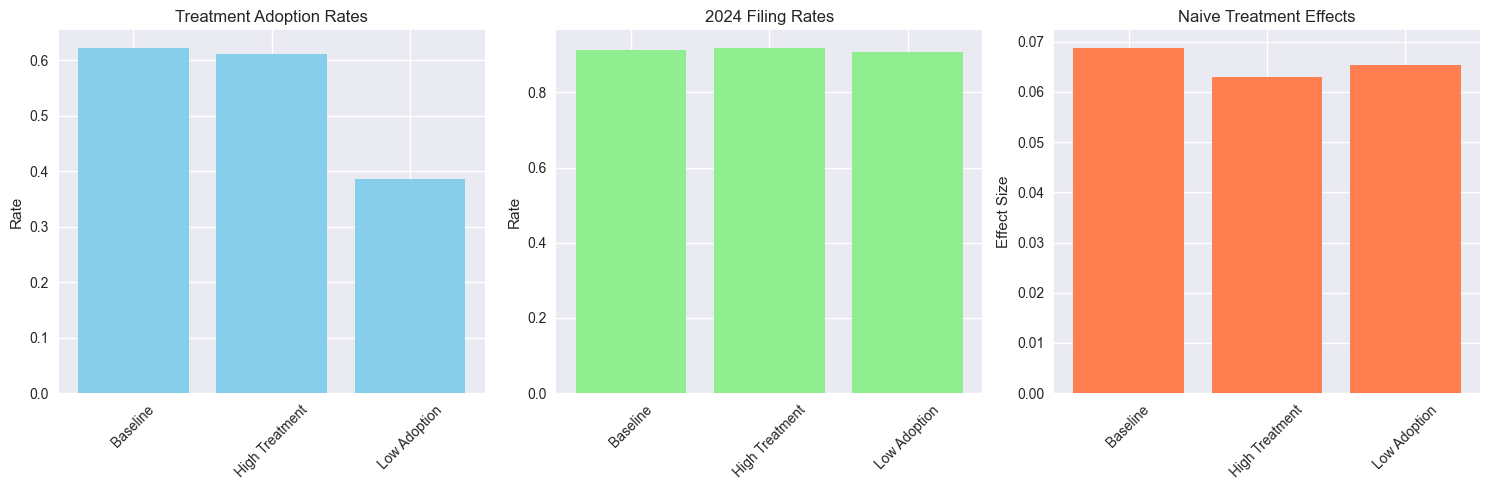

📈 SCENARIO COMPARISON TABLE:
         Scenario  Treatment Rate  Filing Rate 2024  Naive Treatment Effect
0        Baseline           0.622             0.914                   0.069
1  High Treatment           0.611             0.919                   0.063
2    Low Adoption           0.386             0.908                   0.065


In [5]:
# Compare scenarios visually
import matplotlib.pyplot as plt
import pandas as pd

if len(results) > 1:
    # Create comparison DataFrame
    comparison_data = []
    for scenario, result in results.items():
        comparison_data.append({
            'Scenario': scenario.replace('_', ' ').title(),
            'Treatment Rate': result['treatment_rate'],
            'Filing Rate 2024': result['filing_rate_2024'],
            'Naive Treatment Effect': result['naive_effect']
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Treatment rates
    axes[0].bar(comparison_df['Scenario'], comparison_df['Treatment Rate'], color='skyblue')
    axes[0].set_title('Treatment Adoption Rates')
    axes[0].set_ylabel('Rate')
    axes[0].tick_params(axis='x', rotation=45)

    # Filing rates
    axes[1].bar(comparison_df['Scenario'], comparison_df['Filing Rate 2024'], color='lightgreen')
    axes[1].set_title('2024 Filing Rates')
    axes[1].set_ylabel('Rate')
    axes[1].tick_params(axis='x', rotation=45)

    # Treatment effects
    axes[2].bar(comparison_df['Scenario'], comparison_df['Naive Treatment Effect'], color='coral')
    axes[2].set_title('Naive Treatment Effects')
    axes[2].set_ylabel('Effect Size')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("📈 SCENARIO COMPARISON TABLE:")
    print(comparison_df.round(3))
else:
    print("⚠️  Only baseline scenario available for comparison")


## 🔗 **Use the Baseline Scenario for Analysis**

Let's continue with the baseline scenario for our main analysis:


In [6]:
# Use the baseline scenario data
if 'baseline' in results:
    df = results['baseline']['data']
else:
    # Generate baseline if not available
    from src.data_simulation import generate_and_save_data
    df = generate_and_save_data()

print("📊 BASELINE DATASET LOADED")
print("="*40)
print(f"Dataset shape: {df.shape}")
print(f"Treatment rate: {df['used_smart_assistant'].mean():.1%}")
print(f"2024 filing rate: {df['filed_2024'].mean():.1%}")

# Display first few rows
df.head()


📊 BASELINE DATASET LOADED
Dataset shape: (5000, 20)
Treatment rate: 62.2%
2024 filing rate: 91.4%


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,True,81,5,0,False,False,True,64,4,0,6.691056,17,1
1,user_000001,37,<30k,desktop,returning,Midwest,43,False,0,0,0,True,False,True,132,1,0,5.713121,-132,-1
2,user_000002,19,30k-50k,mobile,new,East,61,True,128,7,0,False,False,True,100,9,0,8.407082,28,-2
3,user_000003,66,75k-100k,mobile,new,East,31,True,160,4,1,True,False,True,126,6,0,4.670623,34,-2
4,user_000004,27,30k-50k,desktop,returning,West,85,True,38,2,0,True,True,True,20,2,0,6.396812,18,0


## Load Generated Dataset


In [7]:
# Load the generated dataset
df = pd.read_csv("../data/simulated_users.csv")

# Basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

# First few rows
df.head()


Dataset Shape: (1000, 20)

Column Names:
['user_id', 'age', 'income_bracket', 'device_type', 'user_type', 'region', 'tech_savviness', 'filed_2023', 'time_to_complete_2023', 'sessions_2023', 'support_tickets_2023', 'early_login_2024', 'used_smart_assistant', 'filed_2024', 'time_to_complete_2024', 'sessions_2024', 'support_tickets_2024', 'satisfaction_2024', 'time_improvement', 'session_improvement']


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,True,113,3,0,False,True,True,75,1,0,9.619331,38,2
1,user_000001,37,<30k,desktop,returning,Midwest,43,True,54,1,0,False,False,True,38,3,0,7.416110,16,-2
2,user_000002,19,30k-50k,mobile,new,East,61,True,62,2,0,False,False,True,60,1,0,7.508821,2,1
3,user_000003,66,75k-100k,mobile,new,East,31,True,99,3,0,True,True,True,59,6,0,6.923859,40,-3
4,user_000004,27,30k-50k,desktop,returning,West,85,True,57,3,0,True,True,False,0,0,0,NaN,57,3


In [9]:
# Summary statistics
df.describe()


,age,tech_savviness,time_to_complete_2023,sessions_2023,support_tickets_2023,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,912.000000,1000.000000,1000.000000
mean,44.780000,53.22700,83.709000,2.499000,0.156000,81.348000,2.421000,0.09200,7.745586,2.361000,0.078000
std,13.999414,21.07519,48.793597,1.868017,0.397268,44.250164,2.163432,0.30599,1.286563,51.525892,1.783002
min,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.605680,-160.000000,-7.000000
25%,35.000000,38.00000,56.000000,1.000000,0.000000,53.000000,1.000000,0.00000,6.920067,-12.000000,-1.000000
50%,45.000000,53.00000,90.000000,2.000000,0.000000,84.000000,2.000000,0.00000,7.759784,9.000000,0.000000
75%,55.000000,67.25000,118.000000,4.000000,0.000000,111.250000,3.000000,0.00000,8.636436,28.000000,1.000000
max,80.000000,100.00000,220.000000,10.000000,2.000000,222.000000,13.000000,3.00000,10.000000,219.000000,6.000000


## Key Variables Analysis


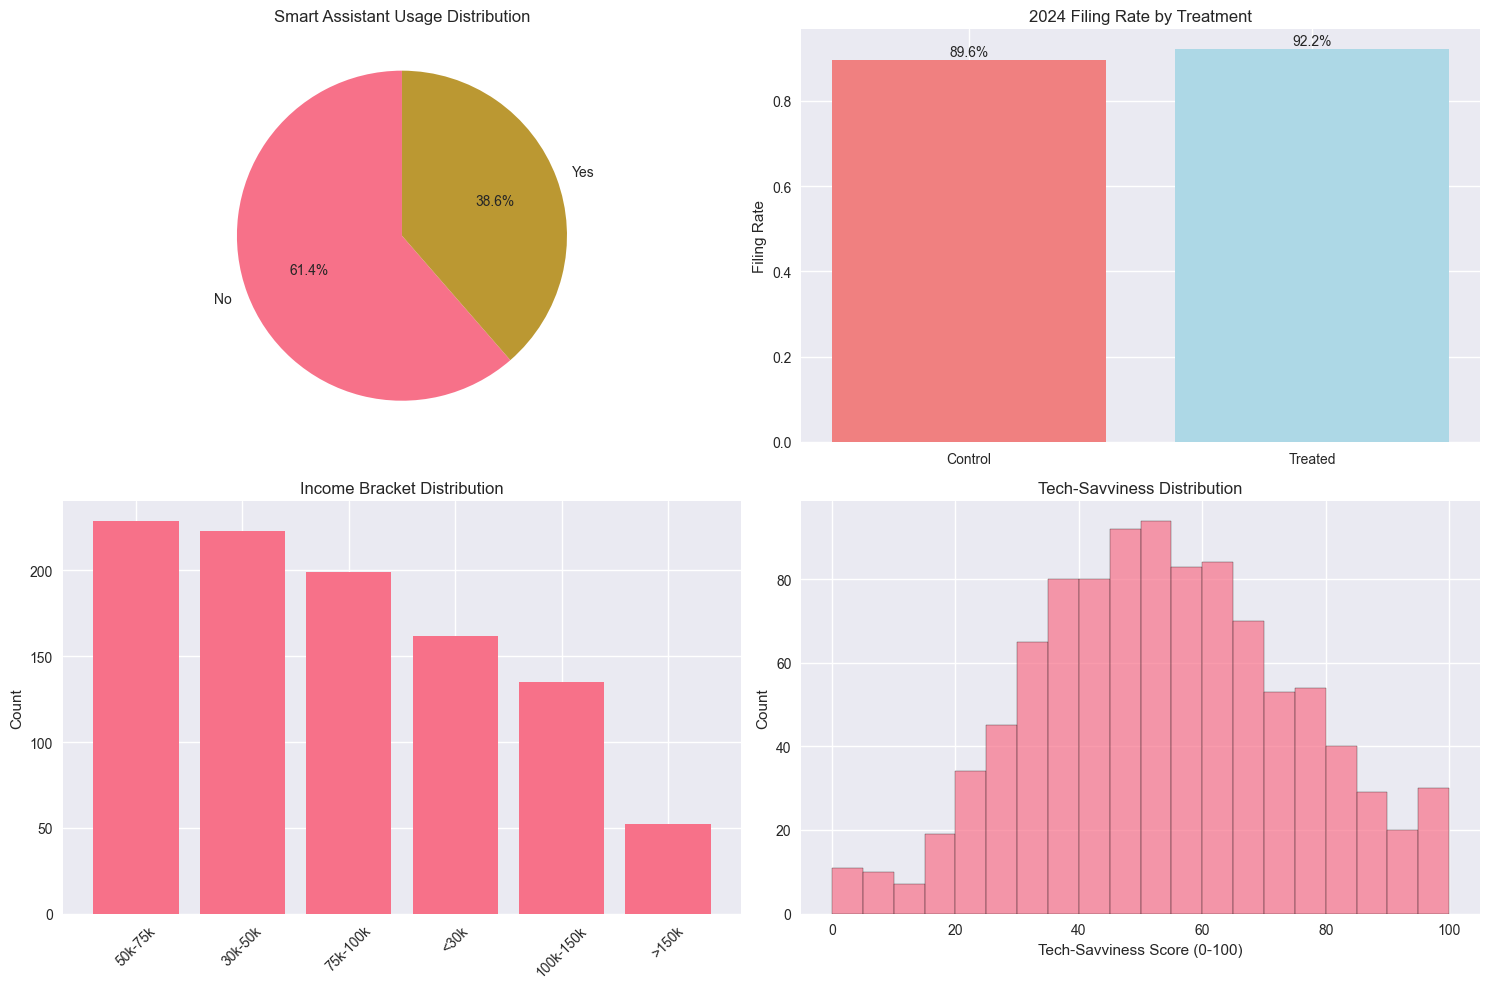

In [11]:
# Treatment and outcome distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Treatment distribution
treatment_counts = df['used_smart_assistant'].value_counts()
axes[0,0].pie(treatment_counts.values, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Smart Assistant Usage Distribution')

# 2024 filing rates by treatment
filing_by_treatment = df.groupby('used_smart_assistant')['filed_2024'].mean()
axes[0,1].bar(['Control', 'Treated'], filing_by_treatment.values, color=['lightcoral', 'lightblue'])
axes[0,1].set_title('2024 Filing Rate by Treatment')
axes[0,1].set_ylabel('Filing Rate')
for i, v in enumerate(filing_by_treatment.values):
    axes[0,1].text(i, v + 0.01, f'{v:.1%}', ha='center')

# Income distribution
income_counts = df['income_bracket'].value_counts()
axes[1,0].bar(range(len(income_counts)), income_counts.values)
axes[1,0].set_xticks(range(len(income_counts)))
axes[1,0].set_xticklabels(income_counts.index, rotation=45)
axes[1,0].set_title('Income Bracket Distribution')
axes[1,0].set_ylabel('Count')

# Tech-savviness distribution
axes[1,1].hist(df['tech_savviness'], bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Tech-Savviness Distribution')
axes[1,1].set_xlabel('Tech-Savviness Score (0-100)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()
